## Model Parameter Comparison Plot

Author: Darshan Mandge, Open Brain Institute

Copyright (c) 2025 Open Brain Institute

This notebook creates a log scatter plot and a heatmap of final parameters of an e-model.
For each paramter, scatter plot for sectionlist (somatic, axonal, apical and basal) are plotted.



The goal of this notebook is to compare and understand the relation between different paramteres in an e-model

Before we begin, here is a brief introduction on e-models and model building pipeline.

- An e-model is usually constructed from intracellular patch clamp data using multi-objective optimisation
- We use the Open Brain Institute (OBI) Platform and our single cell modelling pipeline: [BluePyEModel](https://github.com/openbraininstitute/BluePyEModel)
- The pipeline performs the following steps:
    - extraction of electrical features (e-features) from the electrophysiology data
    - optimisation of the e-features to minimise the z-score of each feature and reduce the overall
    e-model score (sum of e-feature z-scores) 
    - validate the model


- The pipeline store the final e-model details in a json file (EM__*.json) containing details such as
- `fitness`  : the e-model score (sum of e-feature z-scores)
- `parameter`: the hall of fame (best) parameters values which are were selected for different sections of the detailed morphology.  
- `score`    : individual e-feature z-scores
- `features` : individual e-feature absolute values
- `scoreValidation` : validation score
- `passedValidation`(bool) : passed or failed validation
- `seed` : selected seed value from the multiple optimisation runs


In this example, we will use the parameters stored in the EM__*.json to study any relations between parameters of different sections of the neuron e-model.


To learn more about the model building process using BluePyEModel, see the following examples: 

- Local PC [example](https://github.com/openbraininstitute/BluePyEModel/tree/main/examples/L5PC) for  Somatosensory Cortex Layer 5 pyramidal neuron model 
- Using Nexus and OBI Platform [example](https://github.com/openbraininstitute/BluePyEModel/blob/main/examples/nexus/README.md)


## Get the data

If you have the e-model id, you can use the following cell to download the emodel json file. Alternatively, you can get it on the Open Brain Institute platform, on the e-model page you want to get, and click download. It will download a download.zip file. Unzip the file to find the `EM__*.json` file.

In [1]:
from pathlib import Path
from obi_auth import get_token
from entitysdk.client import Client
from entitysdk.models import EModel


emodel_id = "f6e60678-8269-48aa-8218-54a2183ce16d"

token = get_token(environment="staging", auth_mode="daf")
client = Client(environment="staging", token_manager=token)

output_dir = "./emodel_json"
Path(output_dir).mkdir(parents=True, exist_ok=True)

emodel = client.get_entity(
    entity_type=EModel,
    entity_id=emodel_id,
)
assets = client.download_assets(
        emodel,
        selection={"content_type": "application/json"},
        output_path=output_dir,
    )
# select the asset relative to the emodel (EM__), and not to the EModelScript (EMS__)
emodel_json_path = None
for asset in assets:
    if asset.output_path.stem[:3] == "EM_":
        emodel_json_path = asset.output_path
        break
assert emodel_json_path is not None

In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
import seaborn as sns
import pandas as pd
import json
import copy

In [3]:
# emodel_json_path = ...  # put here the path if you have downloaded it on your side
with open(emodel_json_path, "r") as f:
    em = json.load(f)
em.keys()

dict_keys(['fitness', 'parameter', 'score', 'features', 'scoreValidation', 'passedValidation', 'seed'])

Now, we create lists for parameters in the 4 NEURON sectionlists: apical, basal, somatic and axonal. If the e-model you selected/donwloaded has other sectionlsist, the notebook cell below will need appropriate modification

In [4]:
somatic=[]
axonal=[]
basal=[]
apical=[]

param_names_unique = set()

for param_dict in em['parameter']:
    # print(param_dict['name'])
    if 'somatic' in param_dict['name']:
        somatic.append(copy.deepcopy(param_dict))
    if 'axonal' in param_dict['name']:
        axonal.append(copy.deepcopy(param_dict))
    if 'basal' in param_dict['name']:
        basal.append(copy.deepcopy(param_dict))
    if 'apical' in param_dict['name']:
        apical.append(copy.deepcopy(param_dict))
    if '.all' in param_dict['name']:
        somatic.append(copy.deepcopy(param_dict))
        axonal.append(copy.deepcopy(param_dict))
        basal.append(copy.deepcopy(param_dict))
        apical.append(copy.deepcopy(param_dict))
    if '.somadend' in param_dict['name']:
        somatic.append(copy.deepcopy(param_dict))
        basal.append(copy.deepcopy(param_dict))
        apical.append(copy.deepcopy(param_dict))

    param_names_unique.add(param_dict['name'].split('.')[0])

# print the len of each list
print(f"somatic list length = {len(somatic)}")
print(f"axonal list length = {len(axonal)}")
print(f"basal list length = {len(basal)}")
print(f"apical list length = {len(apical)}")
# q. can I convert the set to a list with the same name?
# a. yes, but the order will be different
param_names_unique = list(param_names_unique)
print(f"param_names_unique list length = {len(param_names_unique)}")
print(param_names_unique)

somatic list length = 12
axonal list length = 12
basal list length = 6
apical list length = 10
param_names_unique list length = 13
['gCa_LVAstbar_Ca_LVAst', 'gSK_E2bar_SK_E2', 'g_pas', 'gIhbar_Ih', 'gK_Pstbar_K_Pst', 'e_pas', 'decay_CaDynamics_DC0', 'gSKv3_1bar_SKv3_1', 'gK_Tstbar_K_Tst', 'gNap_Et2bar_Nap_Et2', 'gCa_HVAbar_Ca_HVA2', 'gamma_CaDynamics_DC0', 'gNaTgbar_NaTg']


In [5]:
# group the data by the parameter name and plot a box plot for each parameter
# create a dictionary to hold the data
data_dict = {}
for param_name in param_names_unique:
    data_dict[param_name] = {}
    for temp_dict in somatic:
        if param_name in temp_dict['name']:
            data_dict[param_name]['somatic'] = copy.deepcopy(temp_dict['value'])
    for temp_dict in axonal:
        if param_name in temp_dict['name']:
            data_dict[param_name]['axonal'] = copy.deepcopy(temp_dict['value'])
    for temp_dict in basal:
        if param_name in temp_dict['name']:
            data_dict[param_name]['basal'] = copy.deepcopy(temp_dict['value'])
    for temp_dict in apical:
        if param_name in temp_dict['name']:
            data_dict[param_name]['apical'] = copy.deepcopy(temp_dict['value'])


The dictionary data_dict has all the parameters of the model with the values for 4 sectionlstits.

In [6]:
data_dict

{'gCa_LVAstbar_Ca_LVAst': {'somatic': 0.0006622930104584055,
  'axonal': 0.0018029065747980576,
  'basal': 1.1077694769036426e-05,
  'apical': 0.003978825713989373},
 'gSK_E2bar_SK_E2': {'somatic': 4.9999997198124646e-11,
  'axonal': 0.04555210215064623,
  'apical': 0.05273696299968331},
 'g_pas': {'somatic': 1.950024900179962e-05,
  'axonal': 1.950024900179962e-05,
  'basal': 1.950024900179962e-05,
  'apical': 1.950024900179962e-05},
 'gIhbar_Ih': {'somatic': 0.00012632529009518365,
  'basal': 0.00012632529009518365,
  'apical': 0.00012632529009518365},
 'gK_Pstbar_K_Pst': {'somatic': 0.09036298886686944,
  'axonal': 0.4895706525753729},
 'e_pas': {'somatic': -90.99114013716066,
  'axonal': -90.99114013716066,
  'basal': -90.99114013716066,
  'apical': -90.99114013716066},
 'decay_CaDynamics_DC0': {'somatic': 262.2336124221823,
  'axonal': 154.27480997393874,
  'apical': 30.66685006306855},
 'gSKv3_1bar_SKv3_1': {'somatic': 0.9153961831919066,
  'axonal': 0.5560377732365568,
  'apical

In [7]:
# Create a scatter plot using Plotly
fig = go.Figure(layout=go.Layout(width=800, height=400))
colors = ['red', 'green', 'blue', 'orange']
# Add scatter traces for each compartment
for compartment, color in zip(['somatic', 'axonal', 'basal', 'apical'], colors):
    x = []
    y = []
    for param_name in param_names_unique:
        if compartment in data_dict[param_name]:
            x.append(param_name)
            y.append(data_dict[param_name][compartment])
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='markers',
        name=compartment,
        marker=dict(color=color)
    ))

# Update layout
fig.update_layout(
    title={'text': 'Parameter values for different compartments', 'x': 0.5},
    xaxis_title='Parameter',
    yaxis_title='Parameter Value',
    yaxis_type='log',
    legend_title='Compartment'
)

fig.show()

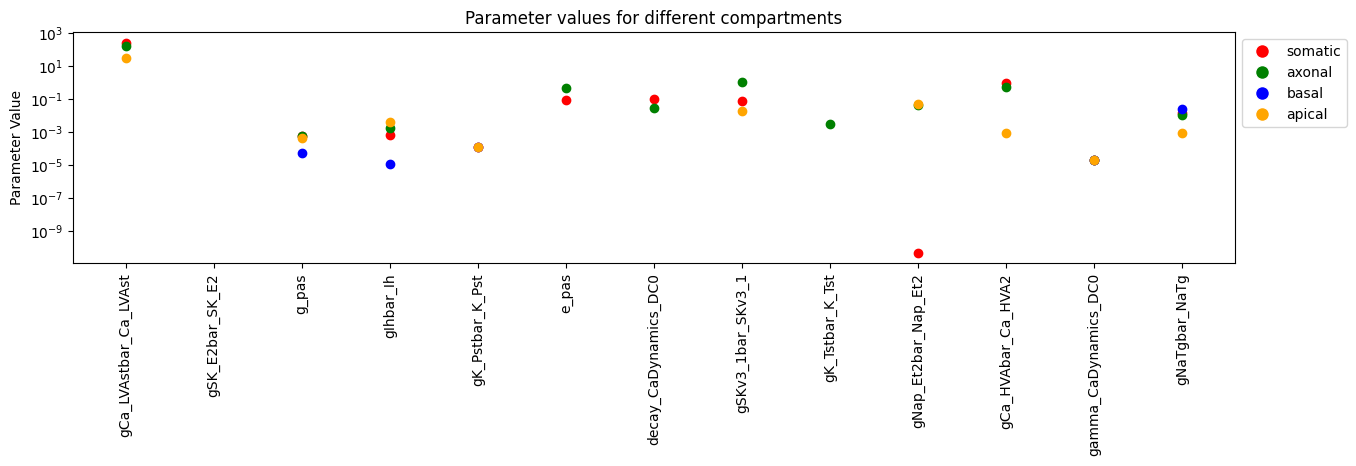

In [8]:
#Same plot using matplotlib: simpler but less interactive

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15, 3))
# use distinct colors for better differentiation
colors = ['red', 'green', 'blue', 'orange']

for i,key in enumerate(sorted(data_dict)):
    # plot the data for each parameter with a different color for each compartment
    for compartment, color in zip(['somatic', 'axonal', 'basal', 'apical'], colors):
        if compartment in data_dict[key]:
            ax.scatter(i, data_dict[key][compartment], color=color, label=compartment)

# set the xticks to the parameter names
ax.set_xticks(range(len(data_dict)))
ax.set_xticklabels(data_dict.keys(), rotation=90)
ax.set_ylabel('Parameter Value')
# log scale for the y-axis
ax.set_yscale('log')
ax.set_title('Parameter values for different compartments')

# Create custom legend handles with the new colors
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, 
                         label=l, markersize=10) 
                  for l, c in zip(['somatic', 'axonal', 'basal', 'apical'], colors)]
ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1), loc='upper left')
plt.show()



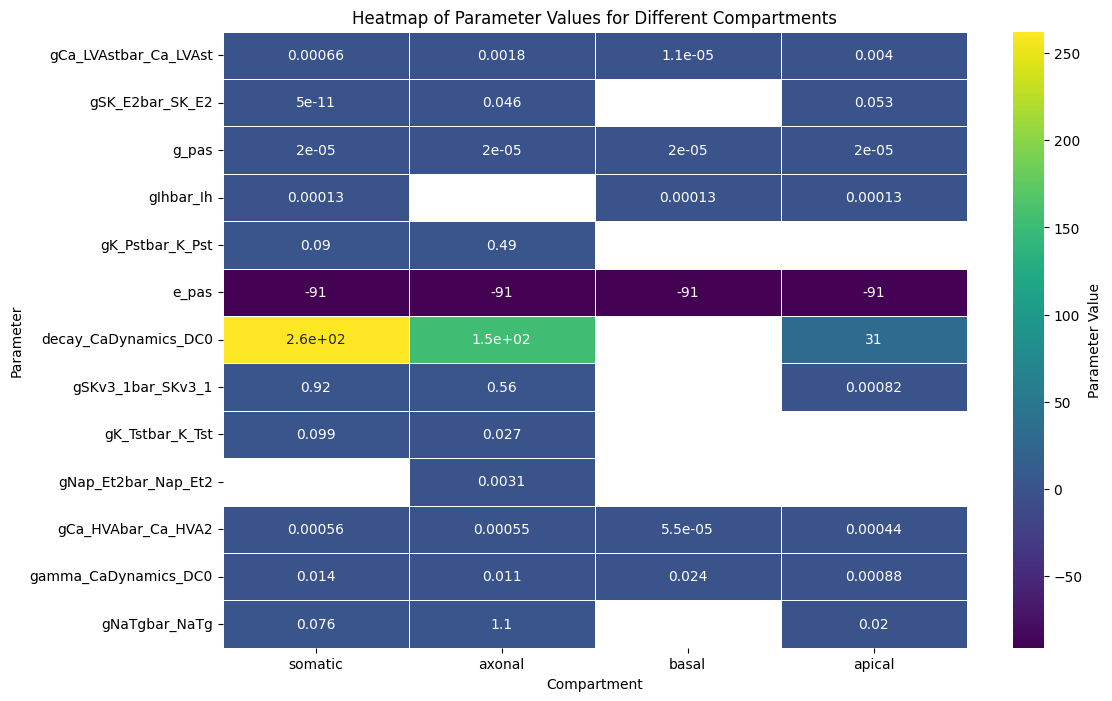

In [9]:
# Convert the data_dict to a DataFrame
df_heatmap = pd.DataFrame(data_dict).T

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_heatmap, annot=True, cmap='viridis', cbar_kws={'label': 'Parameter Value'}, linewidths=.5)
plt.title('Heatmap of Parameter Values for Different Compartments')
plt.xlabel('Compartment')
plt.ylabel('Parameter')
plt.show()